# Laboratoire 3 : Machines à vecteur de support et réseaux neuronaux
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 3                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/11/2019                                              |

## Introduction

Au cours de ce troisième laboratoire, nous allons étudier deux nouveaux algorithmes d'apprentissage supervisé pour résoudre le problème de classification des galaxies : les réseaux neuronaux et les machines à vecteurs de support (SVM). 
Nous allons également apprendre à utiliser la librairie tensorflow en association avec tensorboard pour pouvoir visualiser en temps réel l'évolution de l'apprentissage du réseau de neurones.
Dans un premier temps, nous allons concevoir un modèle de réseaux neuronaux basé sur le Multi-Layer Perceptron. Nous entrainerons ce modèle afin qu'il puisse classer les galaxies en "smooth" ou "spiral" en utilisant l'ensemble des primitives. Nous utiliserons le module keras de Google tensorflow.
Le deuxième modèle d'apprentissage s'appuie sur un modèle d'optimisation convexe dans le cas du SVM. Dans ce cas, nous n'utiliserons qu'une partie des primitives proposées qui seront couplées à nos primitives développées lors du premier laboratoire.

Nous étudierons notamment l'influence des hyperparamètres de ces deux méthodes afin de proposer le modèle le plus optimal dans le cas de notre problème de classification de galaxies. Nous verrons également l'impact de la taille du dataset sur les performances des modèles.

## Question 1

Dans le cas des réseaux neuronaux, l'utilisation d'une méthode de validation croisée prendrait beaucoup de temps. En effet, il faudrait répéter plusieurs tests avec un nombre "d'epochs" conséquent : ceci serait très chronophage. Nous avons donc décidé d'utiliser la méthode de validation hold-out avec 80% de données d'entrainement et 20% de test.

Concernant le modèle SVM, nous utilisons la méthode de cross validation avec 5 groupes de données (cv=5). Contrairement à Hold-out, la validation croisée effectue plusieurs cycles de validation pour réduire la variabilité. Ainsi, la validation croisée à l'avantage de combiner les mesures de l'aptitude à la prédiction pour obtenir une estimation plus précise de la performance de prédiction du modèle.


## Question 2

Nous normalisons nos données grâce à la méthode "normalize" de la librairie preprocessing. La normalisation se fait par rapport à la valeur maximale. Nous avons décidé de normaliser les primitives indépendamment les unes des autres (axis = 0). Par ailleurs, nous avons remarqué avec nos premiers tests que les performances étaient meilleures si l'on normalise par rapport à la valeur maximale (norm = 'max').

Cette fonction est utilisée dans la procédure "get_data()" dans functions.py de la manière suivante :

X = preprocessing.normalize(X, norm='max',axis = 0)

## Question 3

Nous allons d'abord utiliser un réseau neuronal de type "multilayer perceptron" (MLP).
Celui-ci se compose notamment d'une couche d'entrée, une de sortie et d'une ou plusieurs couches cachées. Ce type de réseau de neurones apprend à classifier par une succession de calculs matriciels qu'on appelle propagation et rétropropagation, ces 2 étapes constituent une epoch. 
Ce modèle possède plusieurs hyperparamètres notamment:
. Le nombre de couches cachées
. Le nombre de perceptrons sur les couches cachées
. Le nombre d'itérations (epochs)
. Le taux d'apprentissage (learning rate)
"Dropout" est également un paramètre important. En effet, celui-ci permet de réduire le surapprentissage d'un réseau neuronal en supprimant temporairement des neurones pendant l'entrainement pour être ensuite réactivé dans la phase de test. Dans notre cas, ce paramètre sera fixé à 0.5 pour les couches cachées. C'est-à-dire qu'on laisse une probabilité de 0.5 de retenir la sortie de chaque noeud.

En machine learning, la fonction coût d'un réseau neuronal mesure la "distance" entre la valeur prédite et la valeur réelle. Ici, la fonction de coût que nous avons choisie est "Binary Cross-Entropy Loss". En effet, nous avons choisi cette fonction, car nos valeurs cibles sont binaires, soit "smooth" ou "spiral".


La principale contrainte du modèle MLP est de trouver un compromis entre le temps d'apprentissage et la précision. La première architecture proposée par l'énoncé est de trois couches cachées : 100, 100, 2 (nombre de perceptrons), 60 epochs et un learning rate de 0.0005. Nous avons étudié différents cas avec 60 epochs :  
1 - l'influence du nombre de perceptrons avec un nombre de couches fixé.  
2 - l'influence du nombre de couches avec le même nombre de perceptrons par couche.  
3 - l'influence du learning rate.

Pour la méthode MLP, les algorithmes ont été executés sur un ordinateur avec les caractéristiques suivantes :

Memoire : 15.5GB  
Processor : IntelCore i7-8700 CPU @ 3.2GHz x 12  
Graphics : Titan Xp/PCle/SSE2  
GNOME : 3.28.2  
OS type : 64bit  

In [20]:
# Initialisation
from RN_model import *
from functions import get_data , plot_perf, plot_delay,get_data_GridSearch,plot_Linear_acc,plot_RBF_acc,plot_analyse_grille,plot_sclability_svm,plot_sclability_test
import time
import pandas as pd
from SVC import SVC_rbf,SVCLine,GridSearch_bestparam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard # Pour affichage sur tensorboard
import shutil

In [2]:
# Import and normalize data
X_train, X_test, Y_train, Y_test = get_data()

In [3]:
# Initialisations
layer_sizes = [100, 100, 2]
epochs = 60
learning_rate = 0.0005
batch_size = 100

dropout = 0.5

# Pour affichage
sub_title = ['loss','acc','f1','val_loss','val_acc', 'val_f1']
x_lab = "epochs"

Voici donc nos résultats avec différentes structures de réseaux de neurones :

1 - Influence du nombre de perceptrons: 

In [4]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []

best_accuracy_RN = 0

nb_perceptrons_range = [[5, 4, 4],[100, 100, 2],[500, 500, 500]]                                                                                                                      

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
    
# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for nb_perceptrons in nb_perceptrons_range:                                                                                                                                                  
    model = RN_model(nb_perceptrons, dropout, learning_rate)                                                                                                                              
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])                                                             

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start)    
    cpt+=1   

nothing to delete
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 0s 24us/sample - loss: 0.6887 - acc: 0.5120 - f1: 0.6536 - val_loss: 0.6731 - val_acc: 0.5191 - val_f1: 0.6826
Epoch 2/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.6648 - acc: 0.5352 - f1: 0.6309 - val_loss: 0.6334 - val_acc: 0.7572 - val_f1: 0.8064
Epoch 3/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.6511 - acc: 0.5992 - f1: 0.5064 - val_loss: 0.5992 - val_acc: 0.8197 - val_f1: 0.8459
Epoch 4/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.6336 - acc: 0.6285 - f1: 0.5229 - val_loss: 0.5671 - val_acc: 0.8584 - val_f1: 0.8745
Epoch 5/60
12800/12800 [==============================] - 0s 12us/sample - loss: 0.6214 - acc: 0.6364 - f1: 0.5240 - val_loss: 0.5447 - val_acc: 0.8953 - val_f1: 0.9011
Epoch 6

Epoch 47/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4399 - acc: 0.8109 - f1: 0.7795 - val_loss: 0.2680 - val_acc: 0.9441 - val_f1: 0.9439
Epoch 48/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4302 - acc: 0.8159 - f1: 0.7880 - val_loss: 0.2905 - val_acc: 0.9187 - val_f1: 0.9159
Epoch 49/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4495 - acc: 0.8043 - f1: 0.7721 - val_loss: 0.2939 - val_acc: 0.9159 - val_f1: 0.9130
Epoch 50/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4375 - acc: 0.8108 - f1: 0.7803 - val_loss: 0.2645 - val_acc: 0.9469 - val_f1: 0.9489
Epoch 51/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4347 - acc: 0.8138 - f1: 0.7853 - val_loss: 0.2683 - val_acc: 0.9388 - val_f1: 0.9383
Epoch 52/60
12800/12800 [==============================] - 0s 12us/sample - loss: 0.4400 - acc: 0.8128 - f1: 0.7834 - val_loss: 0.2600 - val_acc: 0.94

Epoch 35/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3826 - acc: 0.8458 - f1: 0.8667 - val_loss: 0.2189 - val_acc: 0.9478 - val_f1: 0.9484
Epoch 36/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3777 - acc: 0.8469 - f1: 0.8681 - val_loss: 0.2091 - val_acc: 0.9578 - val_f1: 0.9594
Epoch 37/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3881 - acc: 0.8430 - f1: 0.8650 - val_loss: 0.2103 - val_acc: 0.9572 - val_f1: 0.9584
Epoch 38/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3807 - acc: 0.8463 - f1: 0.8671 - val_loss: 0.2092 - val_acc: 0.9572 - val_f1: 0.9588
Epoch 39/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3762 - acc: 0.8477 - f1: 0.8679 - val_loss: 0.2129 - val_acc: 0.9553 - val_f1: 0.9559
Epoch 40/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3861 - acc: 0.8417 - f1: 0.8642 - val_loss: 0.2090 - val_acc: 0.95

Epoch 23/60
12800/12800 [==============================] - 1s 50us/sample - loss: 0.1131 - acc: 0.9583 - f1: 0.9591 - val_loss: 0.1046 - val_acc: 0.9569 - val_f1: 0.9587
Epoch 24/60
12800/12800 [==============================] - 1s 51us/sample - loss: 0.1087 - acc: 0.9598 - f1: 0.9608 - val_loss: 0.1048 - val_acc: 0.9606 - val_f1: 0.9626
Epoch 25/60
12800/12800 [==============================] - 1s 52us/sample - loss: 0.1022 - acc: 0.9621 - f1: 0.9632 - val_loss: 0.1015 - val_acc: 0.9591 - val_f1: 0.9602
Epoch 26/60
12800/12800 [==============================] - 1s 51us/sample - loss: 0.1051 - acc: 0.9613 - f1: 0.9623 - val_loss: 0.0974 - val_acc: 0.9638 - val_f1: 0.9647
Epoch 27/60
12800/12800 [==============================] - 1s 50us/sample - loss: 0.1038 - acc: 0.9613 - f1: 0.9624 - val_loss: 0.0968 - val_acc: 0.9622 - val_f1: 0.9629
Epoch 28/60
12800/12800 [==============================] - 1s 52us/sample - loss: 0.1039 - acc: 0.9627 - f1: 0.9641 - val_loss: 0.1023 - val_acc: 0.96

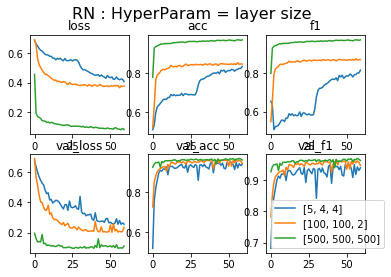

In [5]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in nb_perceptrons_range]                                                                                                                                          

titre = "RN : HyperParam = layer size"   

plot_perf(ho, leg, titre ,sub_title)

Nous remarquons qu'avec trois couches, les performances d'accuracy et de f1_score sont meilleurs dans le cas de [500,500,500] (dépassant les 95%). On remarque également que la perte ("loss") est, en quelque sorte, inversement proportionnelle aux f1_score et accuracy dans ce cas. C'est à dire que pour un f1_score et une accuracy plus faible (nombre de perceptrons inférieur) la valeur de perte sera plus importante que les architectures avec plus de perceptrons.


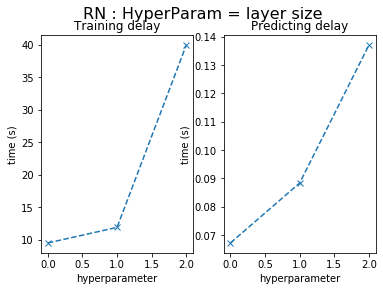

In [6]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

En revanche, ajouter un nombre de perceptrons par couche important influence grandement le temps d'entrainement et de prédiction.


2 : Influence du nombre de couches :

In [7]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

layer_sizes_range = [[100],[100, 100, 2],[100, 100, 100, 100, 100, 2]]

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")

# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for layer_s in layer_sizes_range:
    model = RN_model(layer_s, dropout, learning_rate)
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 

    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)
    cpt+=1

nothing to delete
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 0s 19us/sample - loss: 0.6034 - acc: 0.7112 - f1: 0.7281 - val_loss: 0.4751 - val_acc: 0.8319 - val_f1: 0.8357
Epoch 2/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.4038 - acc: 0.8454 - f1: 0.8508 - val_loss: 0.3356 - val_acc: 0.8791 - val_f1: 0.8864
Epoch 3/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.3046 - acc: 0.8860 - f1: 0.8893 - val_loss: 0.2606 - val_acc: 0.8978 - val_f1: 0.8968
Epoch 4/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.2457 - acc: 0.9121 - f1: 0.9147 - val_loss: 0.2101 - val_acc: 0.9272 - val_f1: 0.9306
Epoch 5/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.2147 - acc: 0.9227 - f1: 0.9249 - val_loss: 0.1815 - val_acc: 0.9312 - val_f1: 0.9332
Epoch 6/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1897 

Epoch 49/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1095 - acc: 0.9615 - f1: 0.9627 - val_loss: 0.1090 - val_acc: 0.9597 - val_f1: 0.9605
Epoch 50/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1120 - acc: 0.9599 - f1: 0.9611 - val_loss: 0.1135 - val_acc: 0.9569 - val_f1: 0.9563
Epoch 51/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1119 - acc: 0.9590 - f1: 0.9605 - val_loss: 0.1087 - val_acc: 0.9600 - val_f1: 0.9616
Epoch 52/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1119 - acc: 0.9590 - f1: 0.9602 - val_loss: 0.1050 - val_acc: 0.9619 - val_f1: 0.9632
Epoch 53/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1110 - acc: 0.9593 - f1: 0.9603 - val_loss: 0.1327 - val_acc: 0.9491 - val_f1: 0.9490
Epoch 54/60
12800/12800 [==============================] - 0s 11us/sample - loss: 0.1067 - acc: 0.9620 - f1: 0.9628 - val_loss: 0.1032 - val_acc: 0.95

Epoch 37/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4170 - acc: 0.7344 - f1: 0.7912 - val_loss: 0.1597 - val_acc: 0.9594 - val_f1: 0.9610
Epoch 38/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4087 - acc: 0.7369 - f1: 0.7933 - val_loss: 0.1666 - val_acc: 0.9522 - val_f1: 0.9547
Epoch 39/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4138 - acc: 0.7353 - f1: 0.7917 - val_loss: 0.1608 - val_acc: 0.9509 - val_f1: 0.9519
Epoch 40/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4130 - acc: 0.7280 - f1: 0.7875 - val_loss: 0.1567 - val_acc: 0.9541 - val_f1: 0.9556
Epoch 41/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4131 - acc: 0.7322 - f1: 0.7900 - val_loss: 0.1969 - val_acc: 0.9475 - val_f1: 0.9477
Epoch 42/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4061 - acc: 0.7345 - f1: 0.7918 - val_loss: 0.1513 - val_acc: 0.95

Epoch 25/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4020 - acc: 0.8310 - f1: 0.8114 - val_loss: 0.2732 - val_acc: 0.9362 - val_f1: 0.9352
Epoch 26/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4127 - acc: 0.8238 - f1: 0.8015 - val_loss: 0.2646 - val_acc: 0.9428 - val_f1: 0.9427
Epoch 27/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4064 - acc: 0.8272 - f1: 0.8057 - val_loss: 0.2545 - val_acc: 0.9444 - val_f1: 0.9450
Epoch 28/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4229 - acc: 0.8176 - f1: 0.7929 - val_loss: 0.2488 - val_acc: 0.9491 - val_f1: 0.9507
Epoch 29/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4090 - acc: 0.8255 - f1: 0.8041 - val_loss: 0.2498 - val_acc: 0.9472 - val_f1: 0.9476
Epoch 30/60
12800/12800 [==============================] - 0s 23us/sample - loss: 0.4068 - acc: 0.8295 - f1: 0.8100 - val_loss: 0.2484 - val_acc: 0.94

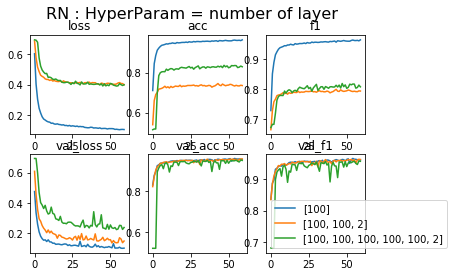

In [8]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in layer_sizes_range]                                                                                                                                              

titre = "RN : HyperParam = number of layer"                                                                                                                                         

plot_perf(ho, leg, titre ,sub_title)

Dans notre problème de classification de galaxies, on note que le les valeurs des accuracy et des f1_scores tendent vers les mêmes performances sur les jeux de données de tests qu'il y ait une, trois ou six couches (nb de perceptrons constant par couche). On remarque également que la valeur de perte est moins importante dans le cas où il y le moins de couche. 


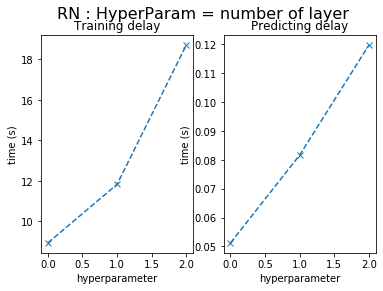

In [9]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Ici, nous remarquons que : plus le nombre de couche est important plus le temps d'entrainement et de prediction sont élevés.

3 - Influence du taux d'apprentissage:

In [10]:
################################## Learning rate                                                                                                                                     
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

l_rate_range = [0.00001,0.0005,0.01]

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")

# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))#time.time())))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for l_rate in l_rate_range:
    model = RN_model(layer_sizes, dropout, l_rate)
    #### Apprentissage
    start = time.time()
    #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])
    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)
    cpt+=1

nothing to delete
Train on 12800 samples, validate on 3200 samples
Epoch 1/60
12800/12800 [==============================] - 0s 25us/sample - loss: 0.6953 - acc: 0.4978 - f1: 0.5019 - val_loss: 0.6930 - val_acc: 0.5191 - val_f1: 0.6817
Epoch 2/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6948 - acc: 0.5192 - f1: 0.6821 - val_loss: 0.6926 - val_acc: 0.5191 - val_f1: 0.6823
Epoch 3/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6941 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6923 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 4/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6950 - acc: 0.5192 - f1: 0.6819 - val_loss: 0.6922 - val_acc: 0.5191 - val_f1: 0.6824
Epoch 5/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6944 - acc: 0.5192 - f1: 0.6819 - val_loss: 0.6923 - val_acc: 0.5191 - val_f1: 0.6820
Epoch 6/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6932 

Epoch 49/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6379 - acc: 0.6672 - f1: 0.6749 - val_loss: 0.6077 - val_acc: 0.7975 - val_f1: 0.8243
Epoch 50/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6347 - acc: 0.6723 - f1: 0.6836 - val_loss: 0.6065 - val_acc: 0.8053 - val_f1: 0.8291
Epoch 51/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6324 - acc: 0.6739 - f1: 0.6809 - val_loss: 0.6031 - val_acc: 0.8019 - val_f1: 0.8273
Epoch 52/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6351 - acc: 0.6698 - f1: 0.6746 - val_loss: 0.6024 - val_acc: 0.8109 - val_f1: 0.8316
Epoch 53/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6298 - acc: 0.6848 - f1: 0.6886 - val_loss: 0.5991 - val_acc: 0.8059 - val_f1: 0.8301
Epoch 54/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6290 - acc: 0.6848 - f1: 0.6891 - val_loss: 0.5977 - val_acc: 0.81

Epoch 37/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3975 - acc: 0.8301 - f1: 0.8072 - val_loss: 0.2223 - val_acc: 0.9566 - val_f1: 0.9577
Epoch 38/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3889 - acc: 0.8354 - f1: 0.8148 - val_loss: 0.2215 - val_acc: 0.9556 - val_f1: 0.9566
Epoch 39/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3978 - acc: 0.8287 - f1: 0.8059 - val_loss: 0.2345 - val_acc: 0.9494 - val_f1: 0.9526
Epoch 40/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4001 - acc: 0.8299 - f1: 0.8080 - val_loss: 0.2713 - val_acc: 0.9259 - val_f1: 0.9234
Epoch 41/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3961 - acc: 0.8276 - f1: 0.8043 - val_loss: 0.2313 - val_acc: 0.9497 - val_f1: 0.9494
Epoch 42/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3867 - acc: 0.8365 - f1: 0.8175 - val_loss: 0.2263 - val_acc: 0.95

Epoch 25/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6924 - val_acc: 0.5191 - val_f1: 0.6820
Epoch 26/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6823 - val_loss: 0.6924 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 27/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6926 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6924 - val_acc: 0.5191 - val_f1: 0.6825
Epoch 28/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6925 - acc: 0.5192 - f1: 0.6820 - val_loss: 0.6925 - val_acc: 0.5191 - val_f1: 0.6822
Epoch 29/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6926 - acc: 0.5192 - f1: 0.6822 - val_loss: 0.6924 - val_acc: 0.5191 - val_f1: 0.6825
Epoch 30/60
12800/12800 [==============================] - 0s 15us/sample - loss: 0.6926 - acc: 0.5192 - f1: 0.6821 - val_loss: 0.6925 - val_acc: 0.51

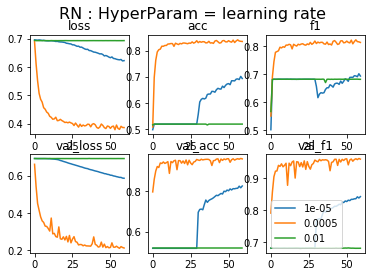

In [11]:
# Traitement pour affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)
                                                                                                                                      
leg = [str(i) for i in l_rate_range]                                                                                                                                                
                                                                                                                                    
titre = "RN : HyperParam = learning rate"                                                                                                                                           

plot_perf(ho, leg, titre ,sub_title)

Ici nous étudions l'influence du learning rate. Nous remarquons que nous devons trouver un compromis dans la valeur du learning rate pour avoir une étude dont les performances sont bonnes. Il semble que la valeur de learning rate qui optimise ces résultats se trouve à 0.0005. 

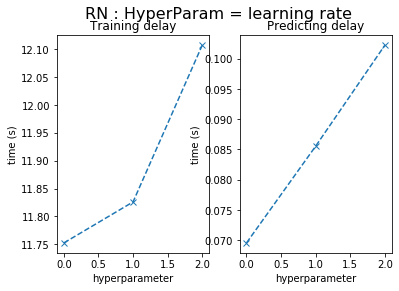

In [12]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)

Nous remarquons ici que c'est la valeur de 0.0005 qui nous apporte les meilleurs performances en terme de temps bien que l'ordre de grandeur est similaire (70sec-80sec), ce qui constitue donc le meilleur compromis.

La fonction de coût que nous avons choisie est "Binary Cross-Entropy Loss". En effet, nous avons choisi cette fonction car nos valeurs cibles sont 0 ou 1, soit "smooth" ou "spiral".

## Question 4


Ici, nous allons faire varier le nombre d'epochs. Nous allons notament visualiser le phénomène de surapprentissage en paramétrant un nombre d'epochs très grand.

In [13]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

epochs_range = [30,60, 2500]                                                                                                                                            
max_ep = max(epochs_range) 

# Suppression de la dernière étude d'hyperparamètre
try:
    tf.reset_default_graph()
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
    
# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(3):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
for ep in epochs_range:                                                                                                                                                            
    model = RN_model(layer_sizes, dropout, learning_rate)                                                                                                                          
    #### Apprentissage                                                                                                                                                             
    start = time.time()                                                                                                                                                            
    #model.fit(X_train, Y_train, batch_size = 100, epochs = 60)                                                                                                                    
    hist_obj = model.fit(X_train, Y_train, batch_size = batch_size, epochs = ep, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])                                                                  

    end = time.time()                                                                                                                                                              
    training_delay_RN.append(end - start)                                                                                                                                          

    ho_tmp = list(hist_obj.history.values())                                                                                                                                       
    ho_tmp = [i + [np.nan for _ in range(max_ep-ep)] for i in ho_tmp ]                                                                                                             
    history_obj.append(ho_tmp)
    #### Prédiction                                                                                                                                                                
    start = time.time()                                                                                                                                                            

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)                                                                                                                           

    end = time.time()                                                                                                                                                              
    predicting_delay_RN.append(end - start) 
    cpt+=1

nothing to delete
Train on 12800 samples, validate on 3200 samples
Epoch 1/30
12800/12800 [==============================] - 0s 25us/sample - loss: 0.6937 - acc: 0.5063 - f1: 0.4580 - val_loss: 0.6834 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 2/30
12800/12800 [==============================] - 0s 14us/sample - loss: 0.6572 - acc: 0.5823 - f1: 0.5971 - val_loss: 0.5613 - val_acc: 0.7644 - val_f1: 0.8080
Epoch 3/30
12800/12800 [==============================] - 0s 14us/sample - loss: 0.5706 - acc: 0.7480 - f1: 0.7329 - val_loss: 0.4784 - val_acc: 0.8866 - val_f1: 0.8895
Epoch 4/30
12800/12800 [==============================] - 0s 14us/sample - loss: 0.5178 - acc: 0.7876 - f1: 0.7672 - val_loss: 0.4209 - val_acc: 0.9131 - val_f1: 0.9138
Epoch 5/30
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4945 - acc: 0.7959 - f1: 0.7731 - val_loss: 0.3813 - val_acc: 0.9281 - val_f1: 0.9301
Epoch 6/30
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4687 

12800/12800 [==============================] - 0s 14us/sample - loss: 0.4155 - acc: 0.8284 - f1: 0.8533 - val_loss: 0.2677 - val_acc: 0.9459 - val_f1: 0.9485
Epoch 19/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4065 - acc: 0.8332 - f1: 0.8568 - val_loss: 0.2599 - val_acc: 0.9447 - val_f1: 0.9464
Epoch 20/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4064 - acc: 0.8316 - f1: 0.8553 - val_loss: 0.2703 - val_acc: 0.9381 - val_f1: 0.9421
Epoch 21/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.3995 - acc: 0.8355 - f1: 0.8589 - val_loss: 0.2510 - val_acc: 0.9488 - val_f1: 0.9501
Epoch 22/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4026 - acc: 0.8369 - f1: 0.8593 - val_loss: 0.2735 - val_acc: 0.9378 - val_f1: 0.9420
Epoch 23/60
12800/12800 [==============================] - 0s 14us/sample - loss: 0.4014 - acc: 0.8366 - f1: 0.8596 - val_loss: 0.2461 - val_acc: 0.9491 - val_f1:

Epoch 6/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4601 - acc: 0.7018 - f1: 0.6505 - val_loss: 0.2679 - val_acc: 0.9294 - val_f1: 0.9291
Epoch 7/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.4491 - acc: 0.7211 - f1: 0.7775 - val_loss: 0.2542 - val_acc: 0.9378 - val_f1: 0.9389
Epoch 8/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.4462 - acc: 0.7214 - f1: 0.7794 - val_loss: 0.2450 - val_acc: 0.9375 - val_f1: 0.9414
Epoch 9/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4417 - acc: 0.7223 - f1: 0.7804 - val_loss: 0.2285 - val_acc: 0.9362 - val_f1: 0.9362
Epoch 10/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4367 - acc: 0.7262 - f1: 0.7829 - val_loss: 0.2170 - val_acc: 0.9444 - val_f1: 0.9461
Epoch 11/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4326 - acc: 0.7237 - f1: 0.7823 - val_loss: 0.1996 - val_a

Epoch 54/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4051 - acc: 0.7423 - f1: 0.7966 - val_loss: 0.1386 - val_acc: 0.9591 - val_f1: 0.9605
Epoch 55/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4034 - acc: 0.7356 - f1: 0.7924 - val_loss: 0.1427 - val_acc: 0.9594 - val_f1: 0.9607
Epoch 56/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4080 - acc: 0.7371 - f1: 0.7934 - val_loss: 0.1417 - val_acc: 0.9591 - val_f1: 0.9603
Epoch 57/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4030 - acc: 0.7412 - f1: 0.7961 - val_loss: 0.1456 - val_acc: 0.9597 - val_f1: 0.9611
Epoch 58/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.4086 - acc: 0.7378 - f1: 0.7936 - val_loss: 0.1550 - val_acc: 0.9509 - val_f1: 0.9516
Epoch 59/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3995 - acc: 0.7431 - f1: 0.7969 - val_loss: 0.1668 - v

12800/12800 [==============================] - 0s 16us/sample - loss: 0.4022 - acc: 0.7377 - f1: 0.7942 - val_loss: 0.1296 - val_acc: 0.9628 - val_f1: 0.9640
Epoch 102/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3997 - acc: 0.7416 - f1: 0.7968 - val_loss: 0.1294 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 103/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.4000 - acc: 0.7391 - f1: 0.7954 - val_loss: 0.1345 - val_acc: 0.9634 - val_f1: 0.9644
Epoch 104/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.4015 - acc: 0.7375 - f1: 0.7935 - val_loss: 0.1305 - val_acc: 0.9628 - val_f1: 0.9640
Epoch 105/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3921 - acc: 0.7426 - f1: 0.7973 - val_loss: 0.1221 - val_acc: 0.9569 - val_f1: 0.9587
Epoch 106/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.3968 - acc: 0.7395 - f1: 0.7960 - val_loss: 0.1263 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3961 - acc: 0.7436 - f1: 0.7983 - val_loss: 0.1207 - val_acc: 0.9653 - val_f1: 0.9665
Epoch 149/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3874 - acc: 0.7416 - f1: 0.7967 - val_loss: 0.1278 - val_acc: 0.9641 - val_f1: 0.9651
Epoch 150/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3890 - acc: 0.7516 - f1: 0.8027 - val_loss: 0.1249 - val_acc: 0.9644 - val_f1: 0.9655
Epoch 151/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3883 - acc: 0.7442 - f1: 0.7989 - val_loss: 0.1323 - val_acc: 0.9609 - val_f1: 0.9624
Epoch 152/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.3936 - acc: 0.7422 - f1: 0.7973 - val_loss: 0.1177 - val_acc: 0.9631 - val_f1: 0.9649
Epoch 153/2500
12800/12800 [==============================] - 0s 17us/sample - loss: 0.3942 - acc: 0.7418 - f1: 0.7968 - val_loss: 0.1153 - val_acc: 0

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3916 - acc: 0.7430 - f1: 0.7983 - val_loss: 0.1287 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 196/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3926 - acc: 0.7409 - f1: 0.7966 - val_loss: 0.1149 - val_acc: 0.9666 - val_f1: 0.9677
Epoch 197/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3890 - acc: 0.7466 - f1: 0.8003 - val_loss: 0.1120 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 198/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3831 - acc: 0.7496 - f1: 0.8024 - val_loss: 0.1128 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 199/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3867 - acc: 0.7467 - f1: 0.8008 - val_loss: 0.1107 - val_acc: 0.9638 - val_f1: 0.9651
Epoch 200/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3836 - acc: 0.7479 - f1: 0.8011 - val_loss: 0.1103 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3854 - acc: 0.7463 - f1: 0.7999 - val_loss: 0.1256 - val_acc: 0.9619 - val_f1: 0.9621
Epoch 243/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3928 - acc: 0.7430 - f1: 0.7981 - val_loss: 0.1074 - val_acc: 0.9647 - val_f1: 0.9664
Epoch 244/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3848 - acc: 0.7466 - f1: 0.8000 - val_loss: 0.1091 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 245/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3790 - acc: 0.7487 - f1: 0.8018 - val_loss: 0.1124 - val_acc: 0.9659 - val_f1: 0.9670
Epoch 246/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3855 - acc: 0.7455 - f1: 0.7996 - val_loss: 0.1150 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 247/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3901 - acc: 0.7394 - f1: 0.7961 - val_loss: 0.1252 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3819 - acc: 0.7470 - f1: 0.8006 - val_loss: 0.1052 - val_acc: 0.9678 - val_f1: 0.9687
Epoch 290/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3837 - acc: 0.7449 - f1: 0.7998 - val_loss: 0.1105 - val_acc: 0.9672 - val_f1: 0.9681
Epoch 291/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3903 - acc: 0.7391 - f1: 0.7957 - val_loss: 0.1243 - val_acc: 0.9606 - val_f1: 0.9614
Epoch 292/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3869 - acc: 0.7422 - f1: 0.7972 - val_loss: 0.1133 - val_acc: 0.9634 - val_f1: 0.9655
Epoch 293/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3845 - acc: 0.7431 - f1: 0.7988 - val_loss: 0.1213 - val_acc: 0.9594 - val_f1: 0.9613
Epoch 294/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3814 - acc: 0.7470 - f1: 0.8006 - val_loss: 0.1037 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3840 - acc: 0.7449 - f1: 0.7997 - val_loss: 0.1108 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 337/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3778 - acc: 0.7494 - f1: 0.8026 - val_loss: 0.1114 - val_acc: 0.9666 - val_f1: 0.9669
Epoch 338/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3839 - acc: 0.7473 - f1: 0.8005 - val_loss: 0.1093 - val_acc: 0.9650 - val_f1: 0.9662
Epoch 339/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3788 - acc: 0.7491 - f1: 0.8027 - val_loss: 0.1213 - val_acc: 0.9606 - val_f1: 0.9631
Epoch 340/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3869 - acc: 0.7376 - f1: 0.7950 - val_loss: 0.1071 - val_acc: 0.9653 - val_f1: 0.9662
Epoch 341/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3859 - acc: 0.7437 - f1: 0.7982 - val_loss: 0.1204 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3801 - acc: 0.7504 - f1: 0.8027 - val_loss: 0.1198 - val_acc: 0.9613 - val_f1: 0.9631
Epoch 384/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3796 - acc: 0.7450 - f1: 0.7996 - val_loss: 0.1142 - val_acc: 0.9688 - val_f1: 0.9699
Epoch 385/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3826 - acc: 0.7410 - f1: 0.7970 - val_loss: 0.1059 - val_acc: 0.9672 - val_f1: 0.9680
Epoch 386/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3790 - acc: 0.7455 - f1: 0.7997 - val_loss: 0.1020 - val_acc: 0.9678 - val_f1: 0.9689
Epoch 387/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3797 - acc: 0.7489 - f1: 0.8023 - val_loss: 0.1104 - val_acc: 0.9697 - val_f1: 0.9702
Epoch 388/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3808 - acc: 0.7434 - f1: 0.7989 - val_loss: 0.1096 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3769 - acc: 0.7496 - f1: 0.8030 - val_loss: 0.1126 - val_acc: 0.9644 - val_f1: 0.9665
Epoch 431/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3864 - acc: 0.7436 - f1: 0.7987 - val_loss: 0.1176 - val_acc: 0.9641 - val_f1: 0.9654
Epoch 432/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3850 - acc: 0.7401 - f1: 0.7966 - val_loss: 0.1172 - val_acc: 0.9628 - val_f1: 0.9640
Epoch 433/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3795 - acc: 0.7452 - f1: 0.7998 - val_loss: 0.1101 - val_acc: 0.9634 - val_f1: 0.9647
Epoch 434/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3793 - acc: 0.7504 - f1: 0.8034 - val_loss: 0.1066 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 435/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3768 - acc: 0.7477 - f1: 0.8014 - val_loss: 0.1115 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3797 - acc: 0.7467 - f1: 0.8011 - val_loss: 0.1186 - val_acc: 0.9616 - val_f1: 0.9636
Epoch 478/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3743 - acc: 0.7496 - f1: 0.8031 - val_loss: 0.1087 - val_acc: 0.9663 - val_f1: 0.9663
Epoch 479/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3821 - acc: 0.7421 - f1: 0.7978 - val_loss: 0.1067 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 480/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3758 - acc: 0.7493 - f1: 0.8027 - val_loss: 0.1028 - val_acc: 0.9631 - val_f1: 0.9641
Epoch 481/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3763 - acc: 0.7498 - f1: 0.8030 - val_loss: 0.1065 - val_acc: 0.9650 - val_f1: 0.9658
Epoch 482/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3846 - acc: 0.7439 - f1: 0.7993 - val_loss: 0.1091 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3821 - acc: 0.7428 - f1: 0.7982 - val_loss: 0.1091 - val_acc: 0.9653 - val_f1: 0.9673
Epoch 525/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3742 - acc: 0.7487 - f1: 0.8025 - val_loss: 0.1115 - val_acc: 0.9638 - val_f1: 0.9652
Epoch 526/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3770 - acc: 0.7488 - f1: 0.8028 - val_loss: 0.1109 - val_acc: 0.9691 - val_f1: 0.9702
Epoch 527/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3734 - acc: 0.7548 - f1: 0.8061 - val_loss: 0.1166 - val_acc: 0.9628 - val_f1: 0.9630
Epoch 528/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3779 - acc: 0.7496 - f1: 0.8030 - val_loss: 0.1243 - val_acc: 0.9594 - val_f1: 0.9612
Epoch 529/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3775 - acc: 0.7497 - f1: 0.8028 - val_loss: 0.1188 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3801 - acc: 0.7441 - f1: 0.7990 - val_loss: 0.0964 - val_acc: 0.9678 - val_f1: 0.9687
Epoch 572/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3775 - acc: 0.7462 - f1: 0.8012 - val_loss: 0.0971 - val_acc: 0.9675 - val_f1: 0.9678
Epoch 573/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3782 - acc: 0.7451 - f1: 0.7994 - val_loss: 0.1033 - val_acc: 0.9619 - val_f1: 0.9627
Epoch 574/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3775 - acc: 0.7456 - f1: 0.8005 - val_loss: 0.1093 - val_acc: 0.9625 - val_f1: 0.9639
Epoch 575/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3752 - acc: 0.7493 - f1: 0.8026 - val_loss: 0.1114 - val_acc: 0.9659 - val_f1: 0.9669
Epoch 576/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3736 - acc: 0.7513 - f1: 0.8035 - val_loss: 0.1032 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3782 - acc: 0.7527 - f1: 0.8047 - val_loss: 0.1055 - val_acc: 0.9638 - val_f1: 0.9650
Epoch 619/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3783 - acc: 0.7470 - f1: 0.8013 - val_loss: 0.0944 - val_acc: 0.9694 - val_f1: 0.9710
Epoch 620/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3782 - acc: 0.7462 - f1: 0.8008 - val_loss: 0.1116 - val_acc: 0.9625 - val_f1: 0.9631
Epoch 621/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3722 - acc: 0.7514 - f1: 0.8040 - val_loss: 0.0991 - val_acc: 0.9731 - val_f1: 0.9737
Epoch 622/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3741 - acc: 0.7492 - f1: 0.8027 - val_loss: 0.0998 - val_acc: 0.9675 - val_f1: 0.9680
Epoch 623/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3772 - acc: 0.7503 - f1: 0.8033 - val_loss: 0.0963 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3784 - acc: 0.7418 - f1: 0.7981 - val_loss: 0.1031 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 666/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3766 - acc: 0.7468 - f1: 0.8008 - val_loss: 0.1018 - val_acc: 0.9697 - val_f1: 0.9712
Epoch 667/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3741 - acc: 0.7458 - f1: 0.8003 - val_loss: 0.0961 - val_acc: 0.9697 - val_f1: 0.9706
Epoch 668/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3678 - acc: 0.7549 - f1: 0.8063 - val_loss: 0.1019 - val_acc: 0.9675 - val_f1: 0.9678
Epoch 669/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3766 - acc: 0.7494 - f1: 0.8022 - val_loss: 0.1017 - val_acc: 0.9647 - val_f1: 0.9652
Epoch 670/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3702 - acc: 0.7516 - f1: 0.8042 - val_loss: 0.1096 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3729 - acc: 0.7497 - f1: 0.8029 - val_loss: 0.1034 - val_acc: 0.9675 - val_f1: 0.9687
Epoch 713/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3721 - acc: 0.7545 - f1: 0.8060 - val_loss: 0.1077 - val_acc: 0.9656 - val_f1: 0.9664
Epoch 714/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3676 - acc: 0.7529 - f1: 0.8055 - val_loss: 0.1015 - val_acc: 0.9684 - val_f1: 0.9696
Epoch 715/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3755 - acc: 0.7504 - f1: 0.8033 - val_loss: 0.0990 - val_acc: 0.9700 - val_f1: 0.9705
Epoch 716/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3726 - acc: 0.7479 - f1: 0.8017 - val_loss: 0.1054 - val_acc: 0.9688 - val_f1: 0.9695
Epoch 717/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3724 - acc: 0.7502 - f1: 0.8037 - val_loss: 0.1080 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3740 - acc: 0.7521 - f1: 0.8045 - val_loss: 0.1065 - val_acc: 0.9641 - val_f1: 0.9650
Epoch 760/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3692 - acc: 0.7502 - f1: 0.8034 - val_loss: 0.1026 - val_acc: 0.9659 - val_f1: 0.9665
Epoch 761/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3727 - acc: 0.7461 - f1: 0.8009 - val_loss: 0.1012 - val_acc: 0.9684 - val_f1: 0.9686
Epoch 762/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3683 - acc: 0.7518 - f1: 0.8042 - val_loss: 0.0969 - val_acc: 0.9678 - val_f1: 0.9688
Epoch 763/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3697 - acc: 0.7533 - f1: 0.8057 - val_loss: 0.0978 - val_acc: 0.9669 - val_f1: 0.9681
Epoch 764/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3651 - acc: 0.7551 - f1: 0.8063 - val_loss: 0.0967 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3753 - acc: 0.7413 - f1: 0.7975 - val_loss: 0.1000 - val_acc: 0.9684 - val_f1: 0.9695
Epoch 807/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3674 - acc: 0.7555 - f1: 0.8071 - val_loss: 0.1044 - val_acc: 0.9684 - val_f1: 0.9692
Epoch 808/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3731 - acc: 0.7491 - f1: 0.8024 - val_loss: 0.1015 - val_acc: 0.9688 - val_f1: 0.9704
Epoch 809/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3710 - acc: 0.7515 - f1: 0.8045 - val_loss: 0.1269 - val_acc: 0.9609 - val_f1: 0.9624
Epoch 810/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3761 - acc: 0.7488 - f1: 0.8025 - val_loss: 0.0965 - val_acc: 0.9678 - val_f1: 0.9691
Epoch 811/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3710 - acc: 0.7507 - f1: 0.8035 - val_loss: 0.1033 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3700 - acc: 0.7461 - f1: 0.8011 - val_loss: 0.0998 - val_acc: 0.9675 - val_f1: 0.9686
Epoch 854/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3760 - acc: 0.7477 - f1: 0.8017 - val_loss: 0.1063 - val_acc: 0.9666 - val_f1: 0.9678
Epoch 855/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3685 - acc: 0.7518 - f1: 0.8047 - val_loss: 0.1031 - val_acc: 0.9684 - val_f1: 0.9696
Epoch 856/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3677 - acc: 0.7530 - f1: 0.8053 - val_loss: 0.1026 - val_acc: 0.9638 - val_f1: 0.9655
Epoch 857/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3715 - acc: 0.7531 - f1: 0.8054 - val_loss: 0.0989 - val_acc: 0.9684 - val_f1: 0.9698
Epoch 858/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3707 - acc: 0.7492 - f1: 0.8026 - val_loss: 0.0973 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3707 - acc: 0.7476 - f1: 0.8018 - val_loss: 0.0985 - val_acc: 0.9681 - val_f1: 0.9689
Epoch 901/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3646 - acc: 0.7564 - f1: 0.8071 - val_loss: 0.1188 - val_acc: 0.9613 - val_f1: 0.9633
Epoch 902/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3715 - acc: 0.7498 - f1: 0.8032 - val_loss: 0.0973 - val_acc: 0.9666 - val_f1: 0.9677
Epoch 903/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3769 - acc: 0.7445 - f1: 0.8001 - val_loss: 0.0955 - val_acc: 0.9688 - val_f1: 0.9702
Epoch 904/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3701 - acc: 0.7490 - f1: 0.8027 - val_loss: 0.0966 - val_acc: 0.9681 - val_f1: 0.9692
Epoch 905/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3678 - acc: 0.7509 - f1: 0.8043 - val_loss: 0.1077 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3683 - acc: 0.7493 - f1: 0.8027 - val_loss: 0.1112 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 948/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3663 - acc: 0.7490 - f1: 0.8027 - val_loss: 0.1010 - val_acc: 0.9672 - val_f1: 0.9683
Epoch 949/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3725 - acc: 0.7471 - f1: 0.8016 - val_loss: 0.1082 - val_acc: 0.9669 - val_f1: 0.9684
Epoch 950/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3675 - acc: 0.7506 - f1: 0.8042 - val_loss: 0.1053 - val_acc: 0.9666 - val_f1: 0.9680
Epoch 951/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3728 - acc: 0.7488 - f1: 0.8027 - val_loss: 0.1018 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 952/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3680 - acc: 0.7513 - f1: 0.8044 - val_loss: 0.1029 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3706 - acc: 0.7514 - f1: 0.8045 - val_loss: 0.0980 - val_acc: 0.9703 - val_f1: 0.9713
Epoch 995/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3726 - acc: 0.7508 - f1: 0.8039 - val_loss: 0.0999 - val_acc: 0.9653 - val_f1: 0.9667
Epoch 996/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3667 - acc: 0.7522 - f1: 0.8047 - val_loss: 0.1121 - val_acc: 0.9628 - val_f1: 0.9641
Epoch 997/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3718 - acc: 0.7535 - f1: 0.8053 - val_loss: 0.1045 - val_acc: 0.9684 - val_f1: 0.9696
Epoch 998/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3619 - acc: 0.7530 - f1: 0.8056 - val_loss: 0.1039 - val_acc: 0.9650 - val_f1: 0.9663
Epoch 999/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3651 - acc: 0.7509 - f1: 0.8038 - val_loss: 0.1018 - val_acc: 0

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3616 - acc: 0.7547 - f1: 0.8066 - val_loss: 0.1019 - val_acc: 0.9663 - val_f1: 0.9675
Epoch 1042/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3690 - acc: 0.7473 - f1: 0.8023 - val_loss: 0.1207 - val_acc: 0.9628 - val_f1: 0.9637
Epoch 1043/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3683 - acc: 0.7545 - f1: 0.8064 - val_loss: 0.1142 - val_acc: 0.9631 - val_f1: 0.9643
Epoch 1044/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3735 - acc: 0.7485 - f1: 0.8027 - val_loss: 0.1076 - val_acc: 0.9672 - val_f1: 0.9682
Epoch 1045/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.7541 - f1: 0.8062 - val_loss: 0.1120 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 1046/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3678 - acc: 0.7518 - f1: 0.8041 - val_loss: 0.1000 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3672 - acc: 0.7527 - f1: 0.8053 - val_loss: 0.1064 - val_acc: 0.9622 - val_f1: 0.9628
Epoch 1089/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3686 - acc: 0.7552 - f1: 0.8066 - val_loss: 0.1021 - val_acc: 0.9669 - val_f1: 0.9684
Epoch 1090/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3633 - acc: 0.7554 - f1: 0.8074 - val_loss: 0.0971 - val_acc: 0.9678 - val_f1: 0.9692
Epoch 1091/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3685 - acc: 0.7502 - f1: 0.8042 - val_loss: 0.1027 - val_acc: 0.9659 - val_f1: 0.9670
Epoch 1092/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3647 - acc: 0.7539 - f1: 0.8060 - val_loss: 0.1355 - val_acc: 0.9609 - val_f1: 0.9611
Epoch 1093/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3755 - acc: 0.7513 - f1: 0.8042 - val_loss: 0.1066 - val_a

12800/12800 [==============================] - 0s 16us/sample - loss: 0.3643 - acc: 0.7571 - f1: 0.8075 - val_loss: 0.1031 - val_acc: 0.9659 - val_f1: 0.9665
Epoch 1136/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3625 - acc: 0.7524 - f1: 0.8056 - val_loss: 0.0989 - val_acc: 0.9672 - val_f1: 0.9685
Epoch 1137/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3651 - acc: 0.7504 - f1: 0.8043 - val_loss: 0.1044 - val_acc: 0.9647 - val_f1: 0.9654
Epoch 1138/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3699 - acc: 0.7482 - f1: 0.8024 - val_loss: 0.1036 - val_acc: 0.9672 - val_f1: 0.9683
Epoch 1139/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3735 - acc: 0.7460 - f1: 0.8010 - val_loss: 0.1177 - val_acc: 0.9609 - val_f1: 0.9614
Epoch 1140/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3718 - acc: 0.7524 - f1: 0.8046 - val_loss: 0.1014 - val_a

Epoch 1182/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3660 - acc: 0.7523 - f1: 0.8052 - val_loss: 0.1014 - val_acc: 0.9719 - val_f1: 0.9729
Epoch 1183/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3623 - acc: 0.7580 - f1: 0.8086 - val_loss: 0.1043 - val_acc: 0.9681 - val_f1: 0.9694
Epoch 1184/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3668 - acc: 0.7510 - f1: 0.8042 - val_loss: 0.1039 - val_acc: 0.9694 - val_f1: 0.9705
Epoch 1185/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3671 - acc: 0.7544 - f1: 0.8065 - val_loss: 0.1058 - val_acc: 0.9684 - val_f1: 0.9693
Epoch 1186/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3692 - acc: 0.7487 - f1: 0.8028 - val_loss: 0.1098 - val_acc: 0.9681 - val_f1: 0.9687
Epoch 1187/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3625 - acc: 0.7504 - f1: 0.8041 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3633 - acc: 0.7519 - f1: 0.8050 - val_loss: 0.1008 - val_acc: 0.9675 - val_f1: 0.9689
Epoch 1230/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3649 - acc: 0.7526 - f1: 0.8052 - val_loss: 0.1162 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 1231/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3674 - acc: 0.7532 - f1: 0.8059 - val_loss: 0.1268 - val_acc: 0.9597 - val_f1: 0.9596
Epoch 1232/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3713 - acc: 0.7530 - f1: 0.8053 - val_loss: 0.1156 - val_acc: 0.9656 - val_f1: 0.9674
Epoch 1233/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3660 - acc: 0.7515 - f1: 0.8043 - val_loss: 0.1116 - val_acc: 0.9641 - val_f1: 0.9658
Epoch 1234/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3640 - acc: 0.7506 - f1: 0.8043 - val_loss: 0.1036 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3590 - acc: 0.7543 - f1: 0.8065 - val_loss: 0.1129 - val_acc: 0.9631 - val_f1: 0.9648
Epoch 1277/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3690 - acc: 0.7476 - f1: 0.8021 - val_loss: 0.1069 - val_acc: 0.9691 - val_f1: 0.9702
Epoch 1278/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3705 - acc: 0.7499 - f1: 0.8036 - val_loss: 0.1103 - val_acc: 0.9691 - val_f1: 0.9692
Epoch 1279/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3651 - acc: 0.7509 - f1: 0.8045 - val_loss: 0.1081 - val_acc: 0.9681 - val_f1: 0.9692
Epoch 1280/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3629 - acc: 0.7529 - f1: 0.8055 - val_loss: 0.1082 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 1281/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3617 - acc: 0.7566 - f1: 0.8078 - val_loss: 0.1117 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3698 - acc: 0.7541 - f1: 0.8063 - val_loss: 0.1090 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 1324/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3629 - acc: 0.7542 - f1: 0.8063 - val_loss: 0.1119 - val_acc: 0.9638 - val_f1: 0.9655
Epoch 1325/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3649 - acc: 0.7520 - f1: 0.8050 - val_loss: 0.1057 - val_acc: 0.9697 - val_f1: 0.9710
Epoch 1326/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3599 - acc: 0.7588 - f1: 0.8090 - val_loss: 0.1200 - val_acc: 0.9603 - val_f1: 0.9616
Epoch 1327/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3679 - acc: 0.7487 - f1: 0.8028 - val_loss: 0.1081 - val_acc: 0.9681 - val_f1: 0.9688
Epoch 1328/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3650 - acc: 0.7530 - f1: 0.8060 - val_loss: 0.1099 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3614 - acc: 0.7553 - f1: 0.8074 - val_loss: 0.1313 - val_acc: 0.9622 - val_f1: 0.9644
Epoch 1371/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3610 - acc: 0.7564 - f1: 0.8078 - val_loss: 0.1083 - val_acc: 0.9675 - val_f1: 0.9689
Epoch 1372/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3592 - acc: 0.7553 - f1: 0.8069 - val_loss: 0.1258 - val_acc: 0.9625 - val_f1: 0.9637
Epoch 1373/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3690 - acc: 0.7505 - f1: 0.8036 - val_loss: 0.1129 - val_acc: 0.9663 - val_f1: 0.9674
Epoch 1374/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3642 - acc: 0.7480 - f1: 0.8025 - val_loss: 0.1104 - val_acc: 0.9653 - val_f1: 0.9670
Epoch 1375/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3643 - acc: 0.7498 - f1: 0.8039 - val_loss: 0.1094 - val_a

Epoch 1417/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3658 - acc: 0.7491 - f1: 0.8034 - val_loss: 0.1163 - val_acc: 0.9678 - val_f1: 0.9691
Epoch 1418/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3597 - acc: 0.7549 - f1: 0.8066 - val_loss: 0.1204 - val_acc: 0.9663 - val_f1: 0.9675
Epoch 1419/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3582 - acc: 0.7547 - f1: 0.8074 - val_loss: 0.1285 - val_acc: 0.9647 - val_f1: 0.9654
Epoch 1420/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3619 - acc: 0.7532 - f1: 0.8061 - val_loss: 0.1275 - val_acc: 0.9647 - val_f1: 0.9663
Epoch 1421/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3632 - acc: 0.7534 - f1: 0.8060 - val_loss: 0.1183 - val_acc: 0.9684 - val_f1: 0.9696
Epoch 1422/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3630 - acc: 0.7575 - f1: 0.8085 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3655 - acc: 0.7527 - f1: 0.8052 - val_loss: 0.1144 - val_acc: 0.9653 - val_f1: 0.9675
Epoch 1465/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3666 - acc: 0.7519 - f1: 0.8050 - val_loss: 0.1135 - val_acc: 0.9644 - val_f1: 0.9651
Epoch 1466/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3674 - acc: 0.7473 - f1: 0.8016 - val_loss: 0.1181 - val_acc: 0.9663 - val_f1: 0.9678
Epoch 1467/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3717 - acc: 0.7492 - f1: 0.8035 - val_loss: 0.1226 - val_acc: 0.9656 - val_f1: 0.9661
Epoch 1468/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3684 - acc: 0.7547 - f1: 0.8060 - val_loss: 0.1287 - val_acc: 0.9606 - val_f1: 0.9623
Epoch 1469/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.7536 - f1: 0.8063 - val_loss: 0.1070 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3585 - acc: 0.7579 - f1: 0.8086 - val_loss: 0.1184 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 1512/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3657 - acc: 0.7477 - f1: 0.8020 - val_loss: 0.1135 - val_acc: 0.9675 - val_f1: 0.9690
Epoch 1513/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3618 - acc: 0.7536 - f1: 0.8061 - val_loss: 0.1137 - val_acc: 0.9666 - val_f1: 0.9680
Epoch 1514/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3600 - acc: 0.7541 - f1: 0.8063 - val_loss: 0.1213 - val_acc: 0.9628 - val_f1: 0.9629
Epoch 1515/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3607 - acc: 0.7538 - f1: 0.8058 - val_loss: 0.1115 - val_acc: 0.9666 - val_f1: 0.9672
Epoch 1516/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3658 - acc: 0.7570 - f1: 0.8083 - val_loss: 0.1151 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3606 - acc: 0.7582 - f1: 0.8094 - val_loss: 0.1158 - val_acc: 0.9659 - val_f1: 0.9673
Epoch 1559/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3564 - acc: 0.7534 - f1: 0.8061 - val_loss: 0.1098 - val_acc: 0.9688 - val_f1: 0.9697
Epoch 1560/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3631 - acc: 0.7564 - f1: 0.8072 - val_loss: 0.1102 - val_acc: 0.9663 - val_f1: 0.9678
Epoch 1561/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3566 - acc: 0.7557 - f1: 0.8079 - val_loss: 0.1234 - val_acc: 0.9647 - val_f1: 0.9659
Epoch 1562/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3566 - acc: 0.7541 - f1: 0.8067 - val_loss: 0.1175 - val_acc: 0.9684 - val_f1: 0.9700
Epoch 1563/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3649 - acc: 0.7539 - f1: 0.8062 - val_loss: 0.1093 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3596 - acc: 0.7552 - f1: 0.8073 - val_loss: 0.1106 - val_acc: 0.9666 - val_f1: 0.9671
Epoch 1606/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3567 - acc: 0.7554 - f1: 0.8074 - val_loss: 0.1120 - val_acc: 0.9678 - val_f1: 0.9691
Epoch 1607/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3630 - acc: 0.7563 - f1: 0.8075 - val_loss: 0.1139 - val_acc: 0.9663 - val_f1: 0.9680
Epoch 1608/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3665 - acc: 0.7484 - f1: 0.8031 - val_loss: 0.1107 - val_acc: 0.9678 - val_f1: 0.9683
Epoch 1609/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3657 - acc: 0.7530 - f1: 0.8053 - val_loss: 0.1112 - val_acc: 0.9666 - val_f1: 0.9683
Epoch 1610/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3645 - acc: 0.7533 - f1: 0.8061 - val_loss: 0.1067 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3594 - acc: 0.7529 - f1: 0.8056 - val_loss: 0.1164 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 1653/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3644 - acc: 0.7475 - f1: 0.8023 - val_loss: 0.1154 - val_acc: 0.9688 - val_f1: 0.9691
Epoch 1654/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3630 - acc: 0.7534 - f1: 0.8059 - val_loss: 0.1159 - val_acc: 0.9681 - val_f1: 0.9688
Epoch 1655/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3612 - acc: 0.7549 - f1: 0.8073 - val_loss: 0.1140 - val_acc: 0.9672 - val_f1: 0.9681
Epoch 1656/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3606 - acc: 0.7532 - f1: 0.8061 - val_loss: 0.1204 - val_acc: 0.9663 - val_f1: 0.9675
Epoch 1657/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3695 - acc: 0.7519 - f1: 0.8051 - val_loss: 0.1166 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3648 - acc: 0.7516 - f1: 0.8046 - val_loss: 0.1112 - val_acc: 0.9669 - val_f1: 0.9686
Epoch 1700/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3605 - acc: 0.7527 - f1: 0.8054 - val_loss: 0.1123 - val_acc: 0.9650 - val_f1: 0.9659
Epoch 1701/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3660 - acc: 0.7476 - f1: 0.8022 - val_loss: 0.1110 - val_acc: 0.9678 - val_f1: 0.9692
Epoch 1702/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3645 - acc: 0.7470 - f1: 0.8021 - val_loss: 0.1209 - val_acc: 0.9675 - val_f1: 0.9678
Epoch 1703/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3593 - acc: 0.7556 - f1: 0.8075 - val_loss: 0.1139 - val_acc: 0.9684 - val_f1: 0.9691
Epoch 1704/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3650 - acc: 0.7542 - f1: 0.8069 - val_loss: 0.1108 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3657 - acc: 0.7498 - f1: 0.8039 - val_loss: 0.1234 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 1747/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3591 - acc: 0.7548 - f1: 0.8070 - val_loss: 0.1283 - val_acc: 0.9663 - val_f1: 0.9678
Epoch 1748/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3652 - acc: 0.7505 - f1: 0.8041 - val_loss: 0.1265 - val_acc: 0.9647 - val_f1: 0.9656
Epoch 1749/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3665 - acc: 0.7518 - f1: 0.8047 - val_loss: 0.1256 - val_acc: 0.9634 - val_f1: 0.9650
Epoch 1750/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3629 - acc: 0.7531 - f1: 0.8053 - val_loss: 0.1249 - val_acc: 0.9666 - val_f1: 0.9674
Epoch 1751/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3636 - acc: 0.7534 - f1: 0.8064 - val_loss: 0.1222 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3648 - acc: 0.7498 - f1: 0.8035 - val_loss: 0.1235 - val_acc: 0.9691 - val_f1: 0.9701
Epoch 1794/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3576 - acc: 0.7522 - f1: 0.8051 - val_loss: 0.1205 - val_acc: 0.9678 - val_f1: 0.9694
Epoch 1795/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3577 - acc: 0.7542 - f1: 0.8065 - val_loss: 0.1243 - val_acc: 0.9659 - val_f1: 0.9667
Epoch 1796/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3656 - acc: 0.7480 - f1: 0.8026 - val_loss: 0.1231 - val_acc: 0.9663 - val_f1: 0.9679
Epoch 1797/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3648 - acc: 0.7526 - f1: 0.8054 - val_loss: 0.1427 - val_acc: 0.9638 - val_f1: 0.9645
Epoch 1798/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3681 - acc: 0.7488 - f1: 0.8031 - val_loss: 0.1208 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.7541 - f1: 0.8065 - val_loss: 0.1238 - val_acc: 0.9709 - val_f1: 0.9720
Epoch 1841/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3623 - acc: 0.7566 - f1: 0.8081 - val_loss: 0.1397 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 1842/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3639 - acc: 0.7531 - f1: 0.8057 - val_loss: 0.1275 - val_acc: 0.9666 - val_f1: 0.9681
Epoch 1843/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3612 - acc: 0.7549 - f1: 0.8072 - val_loss: 0.1197 - val_acc: 0.9669 - val_f1: 0.9680
Epoch 1844/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3662 - acc: 0.7499 - f1: 0.8034 - val_loss: 0.1241 - val_acc: 0.9681 - val_f1: 0.9689
Epoch 1845/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3707 - acc: 0.7453 - f1: 0.8005 - val_loss: 0.1325 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3702 - acc: 0.7500 - f1: 0.8034 - val_loss: 0.1220 - val_acc: 0.9638 - val_f1: 0.9646
Epoch 1888/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3628 - acc: 0.7534 - f1: 0.8058 - val_loss: 0.1167 - val_acc: 0.9672 - val_f1: 0.9682
Epoch 1889/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3627 - acc: 0.7534 - f1: 0.8061 - val_loss: 0.1175 - val_acc: 0.9663 - val_f1: 0.9672
Epoch 1890/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3719 - acc: 0.7455 - f1: 0.8010 - val_loss: 0.1170 - val_acc: 0.9678 - val_f1: 0.9693
Epoch 1891/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3609 - acc: 0.7534 - f1: 0.8062 - val_loss: 0.1182 - val_acc: 0.9650 - val_f1: 0.9664
Epoch 1892/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3612 - acc: 0.7547 - f1: 0.8066 - val_loss: 0.1180 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3659 - acc: 0.7508 - f1: 0.8044 - val_loss: 0.1170 - val_acc: 0.9691 - val_f1: 0.9700
Epoch 1935/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3630 - acc: 0.7556 - f1: 0.8077 - val_loss: 0.1101 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 1936/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3631 - acc: 0.7518 - f1: 0.8049 - val_loss: 0.1304 - val_acc: 0.9644 - val_f1: 0.9661
Epoch 1937/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3593 - acc: 0.7523 - f1: 0.8056 - val_loss: 0.1271 - val_acc: 0.9672 - val_f1: 0.9678
Epoch 1938/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3614 - acc: 0.7577 - f1: 0.8078 - val_loss: 0.1196 - val_acc: 0.9691 - val_f1: 0.9697
Epoch 1939/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3628 - acc: 0.7548 - f1: 0.8067 - val_loss: 0.1187 - val_a

Epoch 1981/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3622 - acc: 0.7544 - f1: 0.8063 - val_loss: 0.1177 - val_acc: 0.9684 - val_f1: 0.9692
Epoch 1982/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3567 - acc: 0.7563 - f1: 0.8081 - val_loss: 0.1268 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 1983/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3613 - acc: 0.7542 - f1: 0.8065 - val_loss: 0.1222 - val_acc: 0.9681 - val_f1: 0.9691
Epoch 1984/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3632 - acc: 0.7565 - f1: 0.8077 - val_loss: 0.1167 - val_acc: 0.9672 - val_f1: 0.9684
Epoch 1985/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3604 - acc: 0.7542 - f1: 0.8069 - val_loss: 0.1175 - val_acc: 0.9694 - val_f1: 0.9707
Epoch 1986/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3623 - acc: 0.7518 - f1: 0.8054 - val_loss

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3627 - acc: 0.7512 - f1: 0.8048 - val_loss: 0.1261 - val_acc: 0.9672 - val_f1: 0.9682
Epoch 2029/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3578 - acc: 0.7523 - f1: 0.8054 - val_loss: 0.1329 - val_acc: 0.9666 - val_f1: 0.9677
Epoch 2030/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3566 - acc: 0.7570 - f1: 0.8078 - val_loss: 0.1292 - val_acc: 0.9688 - val_f1: 0.9699
Epoch 2031/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3584 - acc: 0.7548 - f1: 0.8065 - val_loss: 0.1263 - val_acc: 0.9669 - val_f1: 0.9680
Epoch 2032/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3608 - acc: 0.7563 - f1: 0.8078 - val_loss: 0.1322 - val_acc: 0.9688 - val_f1: 0.9701
Epoch 2033/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3599 - acc: 0.7548 - f1: 0.8070 - val_loss: 0.1294 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3556 - acc: 0.7566 - f1: 0.8085 - val_loss: 0.1322 - val_acc: 0.9669 - val_f1: 0.9680
Epoch 2076/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3596 - acc: 0.7540 - f1: 0.8062 - val_loss: 0.1367 - val_acc: 0.9681 - val_f1: 0.9696
Epoch 2077/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3560 - acc: 0.7607 - f1: 0.8111 - val_loss: 0.1347 - val_acc: 0.9631 - val_f1: 0.9647
Epoch 2078/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3728 - acc: 0.7460 - f1: 0.8009 - val_loss: 0.1281 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 2079/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3634 - acc: 0.7536 - f1: 0.8063 - val_loss: 0.1248 - val_acc: 0.9653 - val_f1: 0.9668
Epoch 2080/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3558 - acc: 0.7552 - f1: 0.8075 - val_loss: 0.1312 - val_a

12800/12800 [==============================] - 0s 20us/sample - loss: 0.3624 - acc: 0.7538 - f1: 0.8067 - val_loss: 0.1175 - val_acc: 0.9694 - val_f1: 0.9705
Epoch 2123/2500
12800/12800 [==============================] - 0s 18us/sample - loss: 0.3578 - acc: 0.7594 - f1: 0.8099 - val_loss: 0.1154 - val_acc: 0.9694 - val_f1: 0.9703
Epoch 2124/2500
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3587 - acc: 0.7564 - f1: 0.8082 - val_loss: 0.1204 - val_acc: 0.9672 - val_f1: 0.9687
Epoch 2125/2500
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3591 - acc: 0.7561 - f1: 0.8081 - val_loss: 0.1204 - val_acc: 0.9700 - val_f1: 0.9708
Epoch 2126/2500
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3629 - acc: 0.7501 - f1: 0.8037 - val_loss: 0.1204 - val_acc: 0.9678 - val_f1: 0.9684
Epoch 2127/2500
12800/12800 [==============================] - 0s 19us/sample - loss: 0.3589 - acc: 0.7595 - f1: 0.8101 - val_loss: 0.1357 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3577 - acc: 0.7547 - f1: 0.8070 - val_loss: 0.1256 - val_acc: 0.9678 - val_f1: 0.9686
Epoch 2170/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3588 - acc: 0.7554 - f1: 0.8080 - val_loss: 0.1409 - val_acc: 0.9656 - val_f1: 0.9666
Epoch 2171/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3545 - acc: 0.7577 - f1: 0.8089 - val_loss: 0.1340 - val_acc: 0.9653 - val_f1: 0.9664
Epoch 2172/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3702 - acc: 0.7523 - f1: 0.8051 - val_loss: 0.1211 - val_acc: 0.9684 - val_f1: 0.9694
Epoch 2173/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3548 - acc: 0.7593 - f1: 0.8099 - val_loss: 0.1271 - val_acc: 0.9659 - val_f1: 0.9674
Epoch 2174/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3574 - acc: 0.7537 - f1: 0.8065 - val_loss: 0.1480 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3614 - acc: 0.7545 - f1: 0.8067 - val_loss: 0.1227 - val_acc: 0.9656 - val_f1: 0.9671
Epoch 2217/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3582 - acc: 0.7517 - f1: 0.8050 - val_loss: 0.1228 - val_acc: 0.9681 - val_f1: 0.9702
Epoch 2218/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3565 - acc: 0.7573 - f1: 0.8089 - val_loss: 0.1435 - val_acc: 0.9634 - val_f1: 0.9640
Epoch 2219/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3563 - acc: 0.7547 - f1: 0.8072 - val_loss: 0.1289 - val_acc: 0.9666 - val_f1: 0.9675
Epoch 2220/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3630 - acc: 0.7480 - f1: 0.8028 - val_loss: 0.1311 - val_acc: 0.9678 - val_f1: 0.9690
Epoch 2221/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3578 - acc: 0.7611 - f1: 0.8110 - val_loss: 0.1220 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3524 - acc: 0.7617 - f1: 0.8113 - val_loss: 0.1308 - val_acc: 0.9697 - val_f1: 0.9701
Epoch 2264/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3569 - acc: 0.7542 - f1: 0.8063 - val_loss: 0.1401 - val_acc: 0.9669 - val_f1: 0.9677
Epoch 2265/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3557 - acc: 0.7563 - f1: 0.8081 - val_loss: 0.1389 - val_acc: 0.9672 - val_f1: 0.9682
Epoch 2266/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3608 - acc: 0.7532 - f1: 0.8058 - val_loss: 0.1334 - val_acc: 0.9675 - val_f1: 0.9685
Epoch 2267/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3663 - acc: 0.7496 - f1: 0.8036 - val_loss: 0.1366 - val_acc: 0.9656 - val_f1: 0.9667
Epoch 2268/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3591 - acc: 0.7533 - f1: 0.8059 - val_loss: 0.1374 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3634 - acc: 0.7514 - f1: 0.8046 - val_loss: 0.1423 - val_acc: 0.9700 - val_f1: 0.9710
Epoch 2311/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3595 - acc: 0.7512 - f1: 0.8050 - val_loss: 0.1400 - val_acc: 0.9703 - val_f1: 0.9720
Epoch 2312/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3606 - acc: 0.7533 - f1: 0.8065 - val_loss: 0.1454 - val_acc: 0.9666 - val_f1: 0.9674
Epoch 2313/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3573 - acc: 0.7522 - f1: 0.8050 - val_loss: 0.1424 - val_acc: 0.9703 - val_f1: 0.9713
Epoch 2314/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3577 - acc: 0.7590 - f1: 0.8099 - val_loss: 0.1497 - val_acc: 0.9656 - val_f1: 0.9672
Epoch 2315/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3536 - acc: 0.7568 - f1: 0.8085 - val_loss: 0.1350 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3590 - acc: 0.7587 - f1: 0.8096 - val_loss: 0.1404 - val_acc: 0.9684 - val_f1: 0.9693
Epoch 2358/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3633 - acc: 0.7530 - f1: 0.8062 - val_loss: 0.1424 - val_acc: 0.9675 - val_f1: 0.9688
Epoch 2359/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.7528 - f1: 0.8058 - val_loss: 0.1413 - val_acc: 0.9684 - val_f1: 0.9694
Epoch 2360/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3503 - acc: 0.7583 - f1: 0.8097 - val_loss: 0.1574 - val_acc: 0.9659 - val_f1: 0.9674
Epoch 2361/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3690 - acc: 0.7497 - f1: 0.8037 - val_loss: 0.1432 - val_acc: 0.9678 - val_f1: 0.9687
Epoch 2362/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3551 - acc: 0.7594 - f1: 0.8099 - val_loss: 0.1427 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3598 - acc: 0.7537 - f1: 0.8060 - val_loss: 0.1367 - val_acc: 0.9656 - val_f1: 0.9671
Epoch 2405/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3587 - acc: 0.7555 - f1: 0.8077 - val_loss: 0.1318 - val_acc: 0.9712 - val_f1: 0.9722
Epoch 2406/2500
12800/12800 [==============================] - 0s 16us/sample - loss: 0.3535 - acc: 0.7590 - f1: 0.8100 - val_loss: 0.1446 - val_acc: 0.9656 - val_f1: 0.9668
Epoch 2407/2500
12800/12800 [==============================] - 0s 20us/sample - loss: 0.3542 - acc: 0.7605 - f1: 0.8110 - val_loss: 0.1429 - val_acc: 0.9663 - val_f1: 0.9673
Epoch 2408/2500
12800/12800 [==============================] - 0s 20us/sample - loss: 0.3640 - acc: 0.7511 - f1: 0.8049 - val_loss: 0.1385 - val_acc: 0.9638 - val_f1: 0.9654
Epoch 2409/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3587 - acc: 0.7556 - f1: 0.8075 - val_loss: 0.1374 - val_a

12800/12800 [==============================] - 0s 15us/sample - loss: 0.3608 - acc: 0.7544 - f1: 0.8065 - val_loss: 0.1404 - val_acc: 0.9688 - val_f1: 0.9697
Epoch 2452/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3562 - acc: 0.7588 - f1: 0.8094 - val_loss: 0.1461 - val_acc: 0.9669 - val_f1: 0.9683
Epoch 2453/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3542 - acc: 0.7547 - f1: 0.8076 - val_loss: 0.1529 - val_acc: 0.9666 - val_f1: 0.9676
Epoch 2454/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3545 - acc: 0.7583 - f1: 0.8093 - val_loss: 0.1574 - val_acc: 0.9634 - val_f1: 0.9651
Epoch 2455/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3610 - acc: 0.7570 - f1: 0.8083 - val_loss: 0.1409 - val_acc: 0.9688 - val_f1: 0.9697
Epoch 2456/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3550 - acc: 0.7588 - f1: 0.8095 - val_loss: 0.1401 - val_a

Epoch 2498/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3668 - acc: 0.7525 - f1: 0.8052 - val_loss: 0.1500 - val_acc: 0.9659 - val_f1: 0.9666
Epoch 2499/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3571 - acc: 0.7538 - f1: 0.8067 - val_loss: 0.1272 - val_acc: 0.9678 - val_f1: 0.9691
Epoch 2500/2500
12800/12800 [==============================] - 0s 15us/sample - loss: 0.3567 - acc: 0.7520 - f1: 0.8052 - val_loss: 0.1317 - val_acc: 0.9697 - val_f1: 0.9708


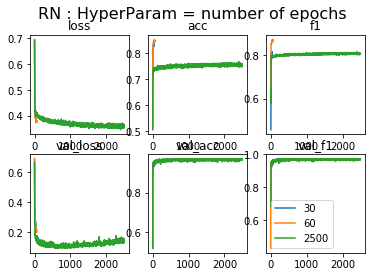

In [14]:
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

leg = [str(i) for i in epochs_range]                                                                                                                                                
                                                                                                                                       
titre = "RN : HyperParam = number of epochs"                                                                                                                                          

plot_perf(ho, leg, titre ,sub_title)

Nous remarquons que les performances (accuracy et f1_score) tendent vers les mêmes taux qu'il y ait 30, 60 ou 5000 itérations. En revanche nous remarquons qu'à partir de 1000 itérations, le val_loss augmente. Ceci illustre le surapprentissage. Le nombre optimal d'itération se situe donc autour de 60.

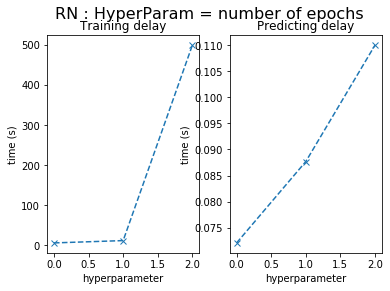

In [15]:
plot_delay(training_delay_RN,predicting_delay_RN,titre)


Notons ici que le temps d'apprentissage et de prédiction croissent avec le nombre d'itération.

## Question 5

Finalement, concernant la classification MLP, nous voyons qu'il faut trouver le bon compromis entre le nombre de couches, le nombre de perceptrons et le learning rate.   


| Hyperparamètre        | Nombre d'epochs |Couches Cachées          | Valeur Accuracy (val_acc) | Valeur f1_score (val_f1) | Valeur de perte (val_loss) | 
|-----------------------|-----------------|------------------------|-----------------|-----------------|------|
| Nombre de perceptrons | 60              |[5,4,4]                 |0.9411           |0,9478           |0.1966|
| Nombre de perceptrons | 60              |[100,100,2]             |0.9550           |0.9571           |0.2044|
| Nombre de perceptrons | 60              |[500,500,500]           |0.9634           |0.9662           |0.1109|
|-----------------------|-----------------|------------------------|-----------------|-----------------|------|
| Nombre de couches     | 60              |[100]                   |0.9634           |0.9631           |0.0987|
| Nombre de couches     | 60              |[100,100,2]             |0.9619           |0.9627           |0.1445|
| Nombre de couches     | 60              |[100,100,100,100,100,2] |0.9419           |0.9417           |0.2213|
|-----------------------|-----------------|------------------------|-----------------|-----------------|------|
| Learning rate (1e-5)  | 60              |[100,100,2]             |0.8553           |0.8594           |0.5234|
| Learning rate (0.0005)| 60              |[100,100,2]             |0.9600           |0.9604           |0.2085|
| Learning rate (0.01)  | 60              |[100,100,2]             |0.5191           |0.6815           |0.6926|
|-----------------------|-----------------|------------------------|-----------------|-----------------|------|
| Nombre d'epochs       | 30              |[100,100,2]             |0.9603           |0.9613           |0.1709|
| Nombre d'epochs       | 60              |[100,100,2]             |0.9584           |0.9598           |0.2056|
| Nombre d'epochs       | 2500            |[100,100,2]             |0.9628           |0.9638           |0.2824|  


- La meilleure solution pour le nombre de perceptrons par couche cachée est [500,500,500] en terme performance. Néanmoins il est préférable de choisir la solution [100,100,2] qui apporte de meilleures performance temporelles.  
- Le nombre de couche cachée apportant le meilleur compromis est de 3 ([100,100,2]).   
- Le learning rate apportant les meilleurs résultat est : 0.0005.
- Ici nous voyons que 2500 itérations apporte les meilleurs performances, nénanmoins elle apporte du sur apprentissage. De plus, le temps de traitement et d'apprentissage est plus long. Le meilleur compromis est donc de 60 itérations.   

En résumé, la meilleure solution pour le réseau MLP est :  
couche [100,100,2],  
learning rate de 0.0005,  
60 epochs.


## Question 6

L'objectif de la méthode SVM est donc de déterminer des hyperplans séparant les classes avec une marge maximale lorsque les ensembles sont linéairement séparables.
Le paramètre C est un facteur qui permet de pénaliser les points qui sont présents dans la marge. Si le point est présent dans la marge mais dont la prédiction est correcte, on peut affecter un poids entre 0 et 1. Dans notre cas, la meilleure performance est quand le paramètre C vaut 10. Cela veut dire que l'on pénalise très fortement les points dont la prédiction est mauvaise.
Par ailleurs, le paramètre gamma permet de déterminer la taille du noyau lorsque les ensembles ne sont pas linéairement séparables. Il faut néanmoins évaluer ce paramètre avec minutie, car il peut être source de sur apprentissage (quand la valeur de gamma est faible) ou de sous apprentissage (gamma élevé).

Pour l'étude de nos deux classificateurs, nous avons utilisé la même de machine dont les performances sont les suivantes :

Memoire : 15.5GB  
Processor : IntelCore i7-8700 CPU @ 3.2GHz x 12  
Graphics : Titan Xp/PCle/SSE2  
GNOME : 3.28.2  
OS type : 64bit  


In [16]:
X_grid,Y_grid = get_data_GridSearch()
Grid=GridSearch_bestparam(X_grid,Y_grid)

start=time.time()
Y_vrai,y_prediction= Y_test,Grid.predict(X_test)
end=time.time()
temps_de_prédiction= end-start
print('Temps de prédiction:',temps_de_prédiction)

ca commence
best param
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
best score
0.967375
Temps de prédiction: 0.5605120658874512


En utilisant l'outil "grid_search" nous obtenons une combinaison des meilleurs paramètres ci-dessus. Nous obtenons dans ce cas une accuracy de plus de 96%.

Analyse Linear


/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:246: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_accuracy.append(df.get_value(i, 35, 'mean_train_Accuracy'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:247: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_time.append(df.get_value(i, 0, 'mean_fit_time'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:248: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_Param_C.append(df.get_value(i, 4, 'param_C'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-mas

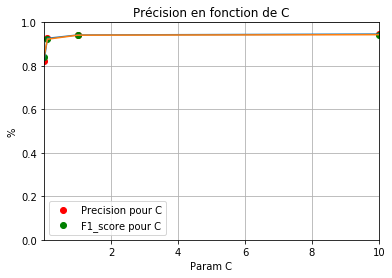

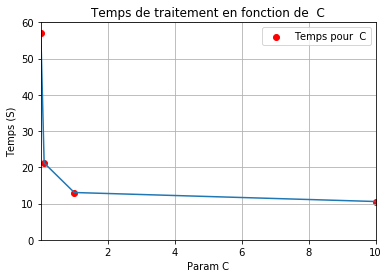

In [17]:
print ('Analyse Linear')
plot_Linear_acc(Grid)

Nous remarquons que l'on obtient rapidement tes performances très statisfaisantes. Par ailleurs, notons que le temps de traitement décroit avec l'augmentation du paramètre C.

Analyse RBF


/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:303: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_accuracy.append(df.get_value(i, 35, 'mean_train_Accuracy'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:304: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_time.append(df.get_value(i, 0, 'mean_fit_time'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-master/GTI770_Laboratoire3_-_BLEA14058906_LETD05129708_LIOT20069605/functions.py:305: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  list_Param_C.append(df.get_value(i, 4, 'param_C'))
/home/ens/AN03460/Desktop/GTI770-master/GTI770-mas

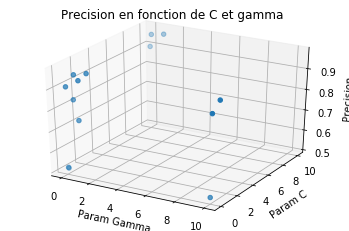

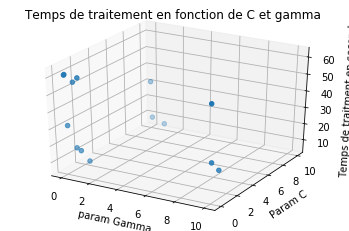

In [18]:
print('Analyse RBF')
plot_RBF_acc(Grid)

In [21]:
print('Table de valeur')

result = Grid.cv_results_
df = pd.DataFrame(data=result)
dfData=df[['param_kernel','param_C','param_gamma','rank_test_Accuracy','mean_test_Accuracy','std_test_Accuracy', 'mean_test_F1','std_test_F1','mean_fit_time', 'std_fit_time','mean_score_time', 'std_score_time']]
dfData= dfData.sort_values(['param_kernel','rank_test_Accuracy','mean_test_F1'],ascending=[True,True,True])
dfData

Table de valeur


,param_kernel,param_C,param_gamma,rank_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,mean_test_F1,std_test_F1,mean_fit_time,std_fit_time,mean_score_time,std_score_time
3,linear,10,NaN,7,0.946063,0.003021,0.947985,0.003004,10.564810,0.514041,1.713644,0.201894
2,linear,1,NaN,9,0.941813,0.003174,0.943939,0.003059,13.049638,0.443526,2.425207,0.316994
1,linear,0.1,NaN,10,0.926500,0.005323,0.929168,0.005085,21.202922,0.350493,4.765865,0.676588
0,linear,0.001,NaN,15,0.823063,0.006238,0.844318,0.005067,57.006002,0.433930,12.979555,0.749534
18,rbf,10,1,1,0.967375,0.002112,0.968615,0.002072,6.067714,0.167237,1.534982,0.130120
14,rbf,1,1,2,0.961375,0.001941,0.962855,0.001872,8.922057,0.184230,2.234164,0.226551
17,rbf,10,0.1,3,0.956250,0.003422,0.957844,0.003256,8.872207,0.370355,2.097033,0.199297
15,rbf,1,10,4,0.952063,0.002334,0.954683,0.002185,19.276927,1.527296,4.634979,0.489022
19,rbf,10,10,5,0.951875,0.002351,0.954324,0.002220,14.385055,1.660831,3.077993,0.372841
10,rbf,0.1,1,6,0.947688,0.004742,0.949900,0.004345,18.018573,0.499937,4.279036,0.316328


In [23]:
print('Résultat de linear avec hyperparametre')
F1,ACC,temps_de_train,temps_de_pred=SVCLine(X_train, Y_train, X_test, Y_test,10)

Résultat de linear avec hyperparametre
[[1448   91]
 [  83 1578]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1539
           1       0.95      0.95      0.95      1661

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200

Temps de training: 3.210716485977173 Temps de prédiction:  0.4415102005004883


In [24]:
print('Résultat de rbf avec hyperparametre')
F1,ACC,temps_de_train,temps_de_pred=SVC_rbf(X_train, Y_train, X_test, Y_test,10,1)

Résultat de rbf avec hyperparametre
[[1486   53]
 [  40 1621]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1539
           1       0.97      0.98      0.97      1661

    accuracy                           0.97      3200
   macro avg       0.97      0.97      0.97      3200
weighted avg       0.97      0.97      0.97      3200

Temps de training: 2.8552114963531494 Temps de prédiction:  0.46399927139282227


## Question 7

On peut aussi tester l'influence de la taille du dataset d'entraînement sur les modèles.
Pour cela, on choisi des hyperparamètres convenables selon les études précédentes.

In [25]:
from functions import plot_sclability_test

In [26]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0

training_size = [200, 1000,5000,12800]

In [27]:
# Suppression de la dernière étude d'hyperparamètre
try:
    shutil.rmtree('./logs')
except:
    print("nothing to delete")

# Callbacks pour affichage des performances dans tensorflow : 1 callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(4):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006
cpt = 0
  
for size in training_size:
    model = RN_model(layer_sizes, dropout, learning_rate) 
    #### Apprentissage
    start = time.time()
    hist_obj = model.fit(X_train[:size], Y_train[:size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]])
    end = time.time()
    training_delay_RN.append(end - start)

    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction
    start = time.time()

    Y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

    end = time.time()
    predicting_delay_RN.append(end - start)
    cpt+=1

# Traitement pour affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)

last_val_acc = []
for i in range(len(training_size)):
    last_val_acc.append(ho[4][epochs-1][i])

nothing to delete
Train on 200 samples, validate on 3200 samples
Epoch 1/60
200/200 [==============================] - 0s 1ms/sample - loss: 0.7791 - acc: 0.4450 - f1: 0.2404 - val_loss: 0.6962 - val_acc: 0.4809 - val_f1: 0.0000e+00
Epoch 2/60
200/200 [==============================] - 0s 185us/sample - loss: 0.7338 - acc: 0.5700 - f1: 0.6125 - val_loss: 0.6913 - val_acc: 0.4831 - val_f1: 0.0098
Epoch 3/60
200/200 [==============================] - 0s 176us/sample - loss: 0.7115 - acc: 0.5400 - f1: 0.5819 - val_loss: 0.6899 - val_acc: 0.5847 - val_f1: 0.4449
Epoch 4/60
200/200 [==============================] - 0s 187us/sample - loss: 0.7162 - acc: 0.4850 - f1: 0.5679 - val_loss: 0.6931 - val_acc: 0.5225 - val_f1: 0.6776
Epoch 5/60
200/200 [==============================] - 0s 175us/sample - loss: 0.6926 - acc: 0.5750 - f1: 0.6463 - val_loss: 0.6931 - val_acc: 0.5188 - val_f1: 0.6815
Epoch 6/60
200/200 [==============================] - 0s 168us/sample - loss: 0.6854 - acc: 0.5400 - f1

Epoch 50/60
200/200 [==============================] - 0s 163us/sample - loss: 0.6910 - acc: 0.5350 - f1: 0.6758 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6820
Epoch 51/60
200/200 [==============================] - 0s 157us/sample - loss: 0.6874 - acc: 0.5600 - f1: 0.6863 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6819
Epoch 52/60
200/200 [==============================] - 0s 153us/sample - loss: 0.6905 - acc: 0.5450 - f1: 0.6806 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 53/60
200/200 [==============================] - 0s 157us/sample - loss: 0.6923 - acc: 0.5150 - f1: 0.6710 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6821
Epoch 54/60
200/200 [==============================] - 0s 151us/sample - loss: 0.6901 - acc: 0.5600 - f1: 0.6868 - val_loss: 0.6927 - val_acc: 0.5191 - val_f1: 0.6823
Epoch 55/60
200/200 [==============================] - ETA: 0s - loss: 0.6884 - acc: 0.5400 - f1: 0.69 - 0s 164us/sample - loss: 0.6901 - acc: 0.5350 - f1: 0.6751 - 

1000/1000 [==============================] - 0s 44us/sample - loss: 0.5073 - acc: 0.7040 - f1: 0.7635 - val_loss: 0.3717 - val_acc: 0.8934 - val_f1: 0.8960
Epoch 39/60
1000/1000 [==============================] - 0s 43us/sample - loss: 0.4831 - acc: 0.7000 - f1: 0.7610 - val_loss: 0.3588 - val_acc: 0.9053 - val_f1: 0.9103
Epoch 40/60
1000/1000 [==============================] - 0s 42us/sample - loss: 0.5079 - acc: 0.6950 - f1: 0.7596 - val_loss: 0.3511 - val_acc: 0.9031 - val_f1: 0.9075
Epoch 41/60
1000/1000 [==============================] - 0s 43us/sample - loss: 0.4861 - acc: 0.6920 - f1: 0.7562 - val_loss: 0.3564 - val_acc: 0.9053 - val_f1: 0.9127
Epoch 42/60
1000/1000 [==============================] - 0s 42us/sample - loss: 0.5026 - acc: 0.6990 - f1: 0.7641 - val_loss: 0.3487 - val_acc: 0.9109 - val_f1: 0.9139
Epoch 43/60
1000/1000 [==============================] - 0s 43us/sample - loss: 0.4905 - acc: 0.7050 - f1: 0.7664 - val_loss: 0.3382 - val_acc: 0.9112 - val_f1: 0.9140
Epoc

5000/5000 [==============================] - 0s 22us/sample - loss: 0.4247 - acc: 0.7236 - f1: 0.7800 - val_loss: 0.2077 - val_acc: 0.9434 - val_f1: 0.9441
Epoch 27/60
5000/5000 [==============================] - 0s 22us/sample - loss: 0.4182 - acc: 0.7348 - f1: 0.7892 - val_loss: 0.1974 - val_acc: 0.9491 - val_f1: 0.9511
Epoch 28/60
5000/5000 [==============================] - 0s 21us/sample - loss: 0.4342 - acc: 0.7216 - f1: 0.7798 - val_loss: 0.2094 - val_acc: 0.9453 - val_f1: 0.9470
Epoch 29/60
5000/5000 [==============================] - 0s 20us/sample - loss: 0.4228 - acc: 0.7256 - f1: 0.7817 - val_loss: 0.2137 - val_acc: 0.9341 - val_f1: 0.9333
Epoch 30/60
5000/5000 [==============================] - 0s 20us/sample - loss: 0.4209 - acc: 0.7354 - f1: 0.7889 - val_loss: 0.1982 - val_acc: 0.9447 - val_f1: 0.9458
Epoch 31/60
5000/5000 [==============================] - 0s 20us/sample - loss: 0.4284 - acc: 0.7288 - f1: 0.7843 - val_loss: 0.2029 - val_acc: 0.9503 - val_f1: 0.9526
Epoc

12800/12800 [==============================] - 0s 19us/sample - loss: 0.4193 - acc: 0.8335 - f1: 0.8562 - val_loss: 0.2845 - val_acc: 0.9441 - val_f1: 0.9451
Epoch 15/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.4154 - acc: 0.8326 - f1: 0.8561 - val_loss: 0.2973 - val_acc: 0.9341 - val_f1: 0.9392
Epoch 16/60
12800/12800 [==============================] - 0s 17us/sample - loss: 0.4126 - acc: 0.8353 - f1: 0.8579 - val_loss: 0.2818 - val_acc: 0.9431 - val_f1: 0.9470
Epoch 17/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.4114 - acc: 0.8321 - f1: 0.8557 - val_loss: 0.2687 - val_acc: 0.9494 - val_f1: 0.9516
Epoch 18/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.4044 - acc: 0.8382 - f1: 0.8607 - val_loss: 0.2570 - val_acc: 0.9481 - val_f1: 0.9497
Epoch 19/60
12800/12800 [==============================] - 0s 18us/sample - loss: 0.4039 - acc: 0.8377 - f1: 0.8597 - val_loss: 0.2540 - val_acc: 0.9503 - val_f1:

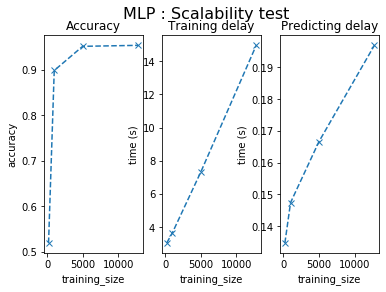

In [28]:
titre = "MLP : Scalability test"         
plot_sclability_test(last_val_acc,training_size,training_delay_RN,predicting_delay_RN, titre )


In [29]:

acc_history =[]
Time_train=[]
Time_test=[]

X_grid,Y_grid = get_data_GridSearch()


In [30]:
for size in training_size:

    print('matrice de confusion')
    F1,ACC,temps_de_train,temps_de_pred=SVC_rbf(X_train[:size], Y_train[:size], X_test[:size], Y_test[:size],10,1)
    nume= F1[0,0]+F1[1,1]
    deno= F1[0,0]+F1[1,1]+F1[0,1]+F1[1,0]
    Acc=nume/deno
    acc_history.append(Acc)
    Time_train.append(temps_de_train)
    Time_test.append(temps_de_pred)
    

matrice de confusion
[[90  4]
 [ 7 99]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        94
           1       0.96      0.93      0.95       106

    accuracy                           0.94       200
   macro avg       0.94      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200

Temps de training: 0.0032508373260498047 Temps de prédiction:  0.0021212100982666016
matrice de confusion
[[480  25]
 [ 21 474]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       505
           1       0.95      0.96      0.95       495

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Temps de training: 0.03289675712585449 Temps de prédiction:  0.022613525390625
matrice de confusion
[[1475   64]
 [  53 1608]]
              precision    recall  f1-score   supp

[0.945, 0.954, 0.9634375, 0.9709375]
[0.0032508373260498047, 0.03289675712585449, 0.46099114418029785, 2.964327573776245]
[0.0021212100982666016, 0.022613525390625, 0.2175915241241455, 0.4733407497406006]


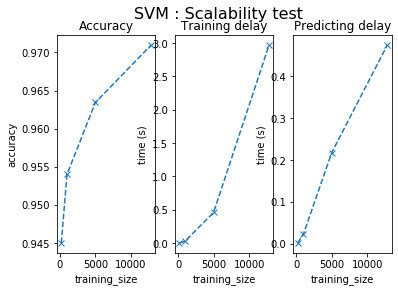

In [31]:
title= "SVM : Scalability test"
print(acc_history)
print(Time_train)
print(Time_test)
plot_sclability_test(acc_history, training_size, Time_train,Time_test,title)

Cette étude nous montre que le modèle SVM n'a pas besoin de beaucoup de données pour obtenir de bons résultats. En effet, on remarque que le modèle MLP a besoin de plus de données pour pouvoir obtenir des performances convenables.
On peut observer aussi que le temps d'entraînement augmente avec la taille du dataset alors que le temps de prédiction est peu affecté.

## Question 8
Du point de vue des performances, il semblerait que le SVM avec noyau rbf, C=10, gamma=1 soit le plus adapté avec des performances avoisinant les 97%.
Bien que l'étude des hyperparamètres soit beaucoup plus long pour le modèle SVM que celui de MLP, les performances finales sont tout de même meilleures.
Dans le cas de la classification des galaxies, il est préférable de privilégier les performances au temps de l'étude des hyperparamètres.

## Question 9
L'idéal serait de mener une étude plus précise des hyperparamètres pour trouver une solution optimale pour le modèle MLP.
Par ailleurs, il faudrait utiliser des méthodes de validation telle que 5-fold cross validation pour la méthode MLP par exemple. Ceci nous aurait permis d'avoir un meilleur support de comparaison de performance. De plus, nous avons utilisé l'optimisation Adam qui nous procurait de meilleurs résultats. On pourrait toutefois étudier plus en détail la méthode de descente de gradient à laquelle il faudrait coupler l'étude du pas de descente de gradient.
Pour ce qui est du modèle SVM, le test de scalabilité a montrer que le SVM n'a pas forcément besoin d'un grand dataset pour fournir de bons résultats. On pourrait donc réduire la taille des échantillons pour accélérer le temps de recherche des hyperparamètres.

## Conlusion
L'objectif de ce troisième laboratoire est d'approfondir notre compréhension du fonctionnement de deux nouvelles méthodes de classification : SVM et MLP. C'est 2 modèles ont été utilisé pour classifier 2 types d'images de galaxies.
Dans les deux cas, les temps d'apprentissage sont bien plus longs que les premiers laboratoires. Dans le cas de MLP, nous obtenons des performances qui s'approchent de 95% avec un temps d'apprentissage de l'ordre de la minute. SVM nous apporte de meilleures performances (97%) avec un temps de prédiction similaire, mais un temps d'apprentissage un peu plus long.
Le désavantage du modèle SVM est le temps nécessaire pour l'étude des hyperparamètres. Toutefois, comme on l'a vu dans le test de scalabilité il serait possible de diminuer ce temps en réduisant la taille du dataset.
Finalement, dans le cas de notre étude, le classificateur le plus adapté est donc SVM avec les paramètres étudiés dans la recherche des meilleurs paramètres.
Comme mentionné précédemment, il pourrait être intéressant de tester le modèle MLP avec une validation croisée pour pouvoir comparer au mieux les deux modèles.